In [12]:
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio as rio
import contextily
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from matplotlib.colors import ListedColormap, rgb2hex
from matplotlib import cm

In [13]:
cat_order = {
    0: "Number of floods",
    1: "Flood area",
    2: "Flood duration",
    3: "Number of floods & flood area",
    4: "Number of floods & flood duration",
    5: "Flood area & flood duration",
    6: "Number of floods, flood area, & flood duration",
    7: "None",
    8: "Not enough information"
}

cat_order_rev = {v: k for k,v in cat_order.items()}

In [53]:
cmap = [[x[0], x[1], x[2], 1] for x in [y for y in plt.get_cmap('Dark2').colors]]

cmap[7] = [0.91, 0.87, 0.84, 0.8]
cmap = np.vstack([cmap, [0.467, 0.533, 0.6, 0.4]])
# cmap[8] = [0.467, 0.533, 0.6, 0.4]
# cmap = np.array([[0.56, 0.24, 0.33, 1],
#                    [0.24, 0.24, 0.49, 1],
#                    [0.33, 0.42, 0.18, 1],
#                    [0.60, 0.51, 0.81, 1],
#                    [0.98, 0.75, 0.81, 1],
#                    [0.57, 0.76, 0.70, 1],
#                    [0.82, 0.46, 0, 1],
#                    [0.91, 0.87, 0.84, 0.8],
#                    [0.467, 0.533, 0.6, 0.4]])

# cmap = np.array([[0.4980392156862745, 0.788235294117647, 0.4980392156862745, 1],
#                  [0.7450980392156863, 0.6823529411764706, 0.8313725490196079, 1],
#                  [0.9921568627450981, 0.7529411764705882, 0.5254901960784314, 1],
#                  [1.0, 1.0, 0.6, 1],
#                  [0.2196078431372549, 0.4235294117647059, 0.6901960784313725, 1],
#                  [0.9411764705882353, 0.00784313725490196, 0.4980392156862745, 1],
#                  [0.7490196078431373, 0.3568627450980392, 0.09019607843137253, 1],
#                  [0.91, 0.87, 0.84, 0.8],
#                  [0.467, 0.533, 0.6, 0.4]])

cmap = ListedColormap(cmap)

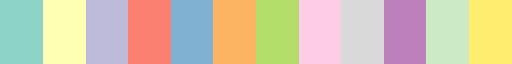

In [62]:
plt.get_cmap('Set3')

In [40]:
cmap = [[x[0], x[1], x[2], 1] for x in [y for y in plt.get_cmap('Accent').colors]]

In [41]:
cmap

[[0.4980392156862745, 0.788235294117647, 0.4980392156862745, 1],
 [0.7450980392156863, 0.6823529411764706, 0.8313725490196079, 1],
 [0.9921568627450981, 0.7529411764705882, 0.5254901960784314, 1],
 [1.0, 1.0, 0.6, 1],
 [0.2196078431372549, 0.4235294117647059, 0.6901960784313725, 1],
 [0.9411764705882353, 0.00784313725490196, 0.4980392156862745, 1],
 [0.7490196078431373, 0.3568627450980392, 0.09019607843137253, 1],
 [0.4, 0.4, 0.4, 1]]

In [16]:
df_diff = gpd.read_file('../../Data/granger_results_diff_adm2_geom.gpkg')

In [17]:
cols = ['sig_nfloods', 'sig_flood_dur', 'sig_flood_area']
df_diff['general_sig'] = df_diff[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis = 1)

In [18]:
df_diff.general_sig.unique()

array(['Not enough information_Not enough information_Not enough information',
       'No_No_No', 'Yes_Yes_No', 'Yes_Yes_Yes', 'No_No_Yes', 'No_Yes_No',
       'Yes_No_No', 'No_Yes_Yes', 'Yes_No_Yes'], dtype=object)

In [19]:
df_diff['general_sig'] = np.where(
    df_diff['general_sig'] == 'Not enough information_Not enough information_Not enough information',
    'Not enough information',
        
        np.where(
        df_diff['general_sig'] == 'No_No_No',
        'None',
        
            np.where(
            df_diff['general_sig'] == 'No_Yes_No',
            'Flood duration',
                
                np.where(
                df_diff['general_sig'] == 'No_No_Yes',
                'Flood area',
                
                    np.where(
                    df_diff['general_sig'] == 'Yes_No_No',
                    'Number of floods',
                        
                        np.where(
                        df_diff['general_sig'] == 'Yes_Yes_No',
                        'Number of floods & flood duration',
                        
                            np.where(
                            df_diff['general_sig'] == 'Yes_No_Yes',
                            'Number of floods & flood area',
                            
                                np.where(
                                df_diff['general_sig'] == 'No_Yes_Yes',
                                'Flood area & flood duration',
                                
                                    np.where(
                                    df_diff['general_sig'] == 'Yes_Yes_Yes',
                                    'Number of floods, flood area, & flood duration', None)))))))))

In [20]:
df_diff['general_sig_ordered'] = df_diff['general_sig'].map(lambda x: cat_order_rev[x])

In [21]:
df_rivers = gpd.read_file("../../Data/HydroRIVERS_v10_af/HydroRIVERS_v10_af.gdb")

In [22]:
df_rivers_proj = df_rivers.to_crs('EPSG:3857')

/Users/connor/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [23]:
df_diff_proj = df_diff.to_crs('EPSG:3857')

/Users/connor/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [24]:
data_dir = "../../Data/"
shp_dir = os.path.join(data_dir, 'ADM shapefiles/')

country_names = sorted(['TCD', 'MLI', 'NER', 'NGA', 'MRT', 'BFA', 'SDN', 'SSD',
                        'ETH', 'UGA', 'KEN', 'SOM', 'ZMB', 'ZWE', 'MOZ', 'MWI'])
country_shapes = {}

for c in range(len(country_names)):
    d = gpd.read_file(os.path.join(shp_dir, '{}_adm/{}_adm0.shp'.format(country_names[c], country_names[c])))
    country_shapes[c] = d

country_df = pd.concat(country_shapes.values(), ignore_index = True)

country_df = country_df.drop(['ISO3', 'NAME_ENGLI',
   'NAME_ISO', 'NAME_FAO', 'NAME_LOCAL', 'NAME_OBSOL', 'NAME_VARIA',
   'NAME_NONLA', 'NAME_FRENC', 'NAME_SPANI', 'NAME_RUSSI',
   'NAME_ARABI', 'NAME_CHINE', 'WASPARTOF', 'CONTAINS', 'SOVEREIGN',
   'ISO2', 'WWW', 'FIPS', 'ISON', 'VALIDFR', 'VALIDTO', 'UNREGION1', 'UNREGION2', 'DEVELOPING', 'CIS',
   'Transition', 'OECD', 'WBREGION', 'WBINCOME', 'WBDEBT', 'WBOTHER',
   'CEEAC', 'CEMAC', 'CEPLG', 'COMESA', 'EAC', 'ECOWAS', 'IGAD',
   'IOC', 'MRU', 'SACU', 'UEMOA', 'UMA', 'PALOP', 'PARTA', 'CACM',
   'EurAsEC', 'Agadir', 'SAARC', 'ASEAN', 'NAFTA', 'GCC', 'CSN',
   'CARICOM', 'EU', 'CAN', 'ACP', 'Landlocked', 'AOSIS', 'SIDS',
   'Islands', 'LDC',], 1)

country_df.loc[country_df['NAME_0'] == 'South Sudan', 'ID_0'] = 222
country_df.loc[country_df['NAME_0'] == 'South Sudan', 'ISO'] = 'SSD'
country_df = country_df.to_crs('EPSG:3857')

/Users/connor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/Users/connor/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


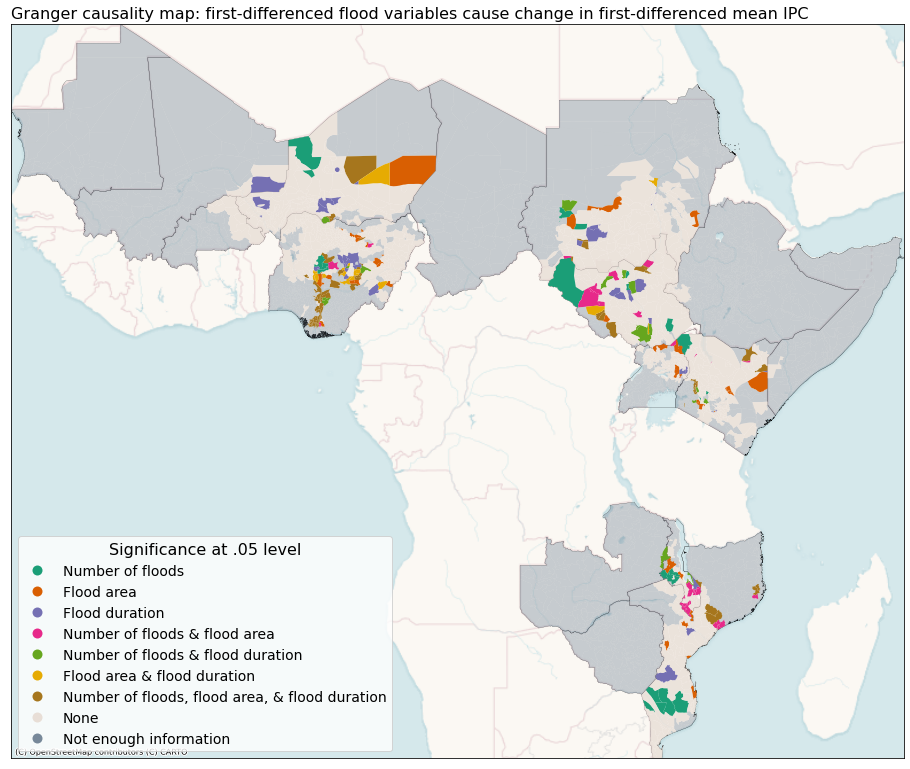

In [54]:
plt.figure(figsize = (16,16))
ax = plt.gca()
df_diff_proj.plot(ax = ax, linewidth = 1, column = 'general_sig_ordered', cmap = cmap, categorical = True,
                  zorder=3,
                  legend = True,
                  legend_kwds = {'title': 'Significance at .05 level',
                                 'title_fontsize': 16,
                                'loc': 'lower left',
                                'fontsize': 14})

country_df.geometry.boundary.plot(ax=ax, color = None, edgecolor = "k", linewidth = 0.2, zorder = 2)
# df_rivers_proj.plot(ax=ax, color = 'blue', linewidth = 0.2, zorder=1)

plt.axis(df_diff_proj.total_bounds[[0,2,1,3]])
plt.title('Granger causality map: first-differenced flood variables cause change in first-differenced mean IPC', fontsize = 16, loc = 'left')

def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

replace_legend_items(ax.get_legend(), cat_order)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

contextily.add_basemap(ax, source = contextily.providers.CartoDB.VoyagerNoLabels)

## Write selected seasons to outfile

In [9]:
flood_data = gpd.read_file('../../Data/flood_ipc_seasonal_adm1_timeseries.gpkg')

In [10]:
flood_data = flood_data.drop('geometry', axis = 1)

In [12]:
granger_diff_floods = pd.merge(flood_data, df_diff.drop('geometry', axis = 1),
                                      on = ['Name', 'ADMIN1'])
granger_diff_floods = granger_diff_floods.loc[granger_diff_floods['general_sig'] != 'Not enough information']

In [24]:
granger_deseasoned_diff_floods = pd.merge(flood_data, df_deseasoned.drop('geometry', axis = 1),
                                         on = ['Name', 'ADMIN1'])

granger_deseasoned_diff_floods = granger_deseasoned_diff_floods.loc[granger_deseasoned_diff_floods['general_sig'] != 'Not enough information']

In [13]:
granger_diff_floods = granger_diff_floods.loc[granger_diff_floods.no_floods_diff > 0]

In [25]:
granger_deseasoned_diff_floods = granger_deseasoned_diff_floods.loc[granger_deseasoned_diff_floods.no_floods_deseasoned_diff > 0]

In [16]:
granger_diff_floods.to_csv('../../Deliverables/Granger causality/granger_results_diff_floods_adm1.csv')

In [26]:
granger_deseasoned_diff_floods.to_csv('../../Deliverables/Granger causality/granger_results_deseasoned_diff_floods_adm1.csv')

In [26]:
keep_cols = ['Name', 'ADMIN1',
       'ADMIN2', 'ALIASES', 'LZcode_fin', 'FIDcalc', 'Year', 'Month',
       'datetime_end', 'datetime_start', 'p-value_nfloods',
       'p-value_flood_dur', 'p-value_flood_area', 'sig_nfloods',
       'sig_flood_dur', 'sig_flood_area', 'general_sig']

granger_diff_floods_reduced = granger_diff_floods[keep_cols]
granger_deseasoned_diff_floods_reduced = granger_deseasoned_diff_floods[keep_cols]

In [154]:
granger_diff_floods_reduced.columns

Index(['Name', 'ADMIN1', 'ADMIN2', 'ALIASES', 'LZcode_fin', 'FIDcalc', 'Year',
       'Month', 'datetime_end', 'datetime_start', 'p-value_nfloods',
       'p-value_flood_dur', 'p-value_flood_area', 'sig_nfloods',
       'sig_flood_dur', 'sig_flood_area', 'general_sig'],
      dtype='object')

## Make bar chart

In [44]:
df_pop = gpd.read_file(os.path.join("../../Data", "IPC", "LZ_adm2_geometryFix_population.gpkg"))

In [45]:
df_pop = df_pop.rename(columns = {'ADMIN0': 'Name'})

In [46]:
df_diff_pop = pd.merge(df_diff, df_pop, on = ['Name', 'ADMIN1', 'ADMIN2', 'FIDcalc'], how = 'left')

In [47]:
import plotly.express as px

In [67]:
df_plot = df_diff_pop.loc[df_diff_pop['general_sig'] != "Not enough information"].groupby('general_sig')\
                     .agg({'2020_pop': 'sum'}).reset_index()

df_plot['sig_group'] = df_plot['general_sig'].map(lambda x: "No" if x == 'None' else "Yes")

fig = px.bar(
    df_plot,
    x = 'sig_group',
    y = '2020_pop',
    color = 'general_sig',
    category_orders = {'general_sig': ['Number of floods', 'Flood area', 'Flood duration',
                                      'Number of floods & flood area', 'Number of floods & flood duration',
                                      'Flood area & flood duration', 'Number of floods, flood area, & flood duration',
                                      'None']},
    color_discrete_sequence=[rgb2hex(c) for c in cmap.colors],
    labels={'2020_pop': 'Population (2020)',
           'general_sig': 'Flood effect category',
           'sig_group': 'Regional food security significantly affected by floods'},
    template = "plotly_white"
)

fig.update_layout(showlegend=True)
fig.show()

In [79]:
fig = px.choropleth(
        df_diff_pop,
        color = 'general_sig'
)

fig.show()

In [80]:
type(df_diff_pop)

geopandas.geodataframe.GeoDataFrame

In [132]:
colors = [rgb2hex(c) for c in cmap.colors]

In [133]:
colors

['#9e425c',
 '#6666b5',
 '#546b2e',
 '#bdb2d4',
 '#ffbacc',
 '#91c2b2',
 '#ffb85c',
 '#ffffff',
 '#778899']